In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

# Actor-Critic Algorithm

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.net(x)

In [3]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

In [4]:
class ActorCritic:
    def __init__(
            self,
            state_dim,
            hidden_dim,
            action_dim,
            actor_lr,
            critic_lr,
            gamma,
            device
    ):
        self.gamma = gamma
        self.device = device

        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.long).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_error = td_target - self.critic(states)
        log_probs = torch.log(self.actor(states).gather(1, actions))

        actor_loss = -torch.mean(log_probs * td_error.detach())
        critic_loss = F.mse_loss(self.critic(states), td_target.detach())

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        self.actor_optimizer.step()
        self.critic_optimizer.step()

In [5]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)

seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n

agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_235236/4037325965.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392067780/work/torch/csrc/utils/tensor_new.cpp:261.)
  states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s, episode=1000, return=200

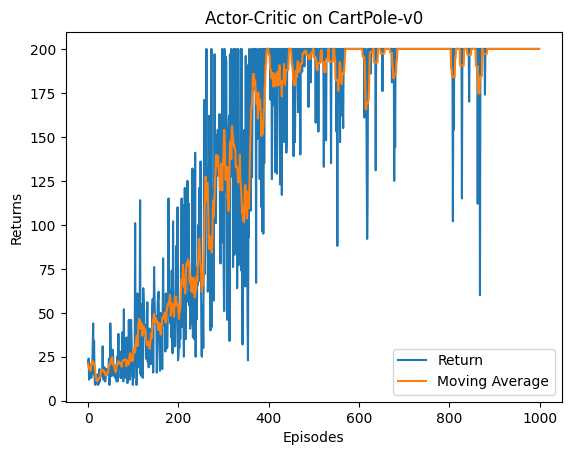

In [6]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, return_list, label='Return')
plt.plot(episodes_list, mv_return, label='Moving Average')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()